## Homework 4 

#### Help: https://github.com/deadskull7/Pneumonia-Diagnosis-using-XRays-96-percent-Recall/blob/master/Pneumonia%20Diagnosis%20using%20Lung's%20XRay%20.ipynb

In [3]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


In [2]:
print(os.listdir("/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/"))

['.DS_Store', 'test', 'train', 'val']


In [4]:
print(os.listdir("/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/train/"))

['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [5]:
TRAIN_DIR = "/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/train/"
TEST_DIR =  "/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/test/"

### Preprocessing

In [6]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [7]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [8]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [9]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 1342/1342 [07:52<00:00,  3.03it/s]


In [10]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 234/234 [01:36<00:00,  2.37it/s]


In [11]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [12]:
print(y_train.shape,'\n',y_test.shape)


(5216,) 
 (624,)


In [13]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


#### The arrays are not normalized because they have already been provided in the necessary format.

In [14]:
print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [15]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
---------------------------------------------------------------------------------------------------------------


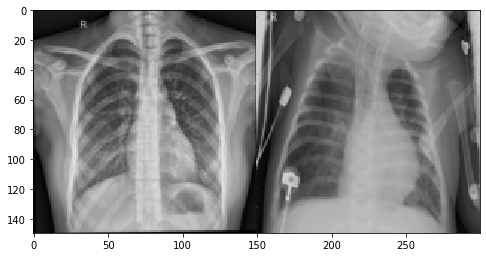

(Left) - No Pneumonia Vs (Right) - Pneumonia
---------------------------------------------------------------------------------------------------------------


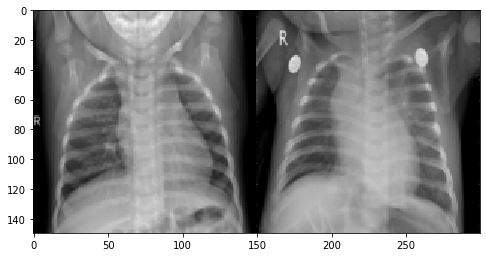

(Left) - No Pneumonia Vs (Right) - Pneumonia
---------------------------------------------------------------------------------------------------------------


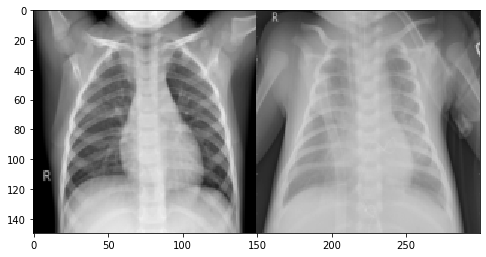

(Left) - No Pneumonia Vs (Right) - Pneumonia
---------------------------------------------------------------------------------------------------------------


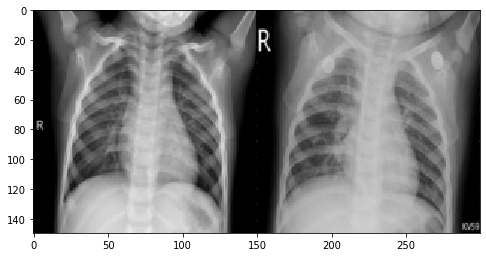

(Left) - No Pneumonia Vs (Right) - Pneumonia
---------------------------------------------------------------------------------------------------------------


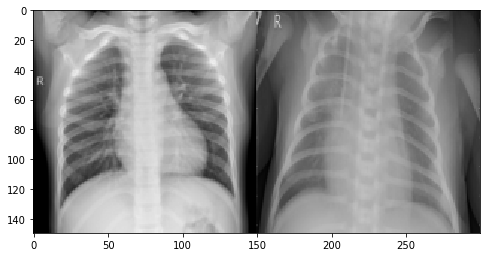

In [17]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("---------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(8,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

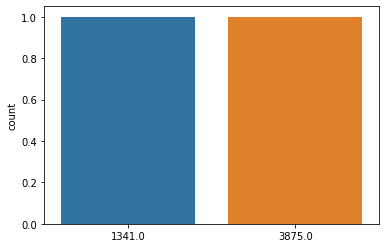

In [18]:
import seaborn as sns
count = y_train.sum(axis = 0)
sns.countplot(x = count)

#### The classes are imbalanced therefore validation accuracy won't be a good metric to analyze the model performance , We will also have to take precision , recall and confusion matrix into account.

In [19]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

//anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


#### Callbacks to reduce learning rate timely after monitoring a quantity.


In [20]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


#### Making checkpoints timely to check and save the best model performance till last and also avoiding further validation accuracy drop due to overfitting.

In [22]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [23]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

#### Other Hyperparameters like learning rates, epochs, batch size , no. of filters , activation function have been tuned repeatedly to achieve better results.

In [25]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150),dim_ordering="th"))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu',dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150),dim_ordering="th"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu',dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same",dim_ordering="th"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu',dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same",dim_ordering="th"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu',dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu',dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", input_shape=(3, 150, 1..., data_format="channels_first")`
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu", data_format="channels_first")`
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(3, 150, 1..., data_format="channels_first")`
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWa

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 37, 37)       

In [26]:
batch_size = 256
epochs = 6

In [27]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

W0926 21:32:07.358865 4669081024 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - 213s 41ms/step - loss: 0.5643 - accuracy: 0.7394 - val_loss: 0.6403 - val_accuracy: 0.6250
Epoch 2/6


//anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
//anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5216/5216 [==============================] - 210s 40ms/step - loss: 0.4225 - accuracy: 0.7689 - val_loss: 0.4952 - val_accuracy: 0.7780
Epoch 3/6
5216/5216 [==============================] - 208s 40ms/step - loss: 0.3528 - accuracy: 0.8448 - val_loss: 0.5520 - val_accuracy: 0.7388
Epoch 4/6
5216/5216 [==============================] - 205s 39ms/step - loss: 0.3051 - accuracy: 0.8678 - val_loss: 0.5302 - val_accuracy: 0.7756
Epoch 5/6
5216/5216 [==============================] - 206s 39ms/step - loss: 0.2596 - accuracy: 0.8917 - val_loss: 0.4417 - val_accuracy: 0.8101
Epoch 6/6
5216/5216 [==============================] - 208s 40ms/step - loss: 0.2199 - accuracy: 0.9150 - val_loss: 0.7870 - val_accuracy: 0.7604


In [29]:
history

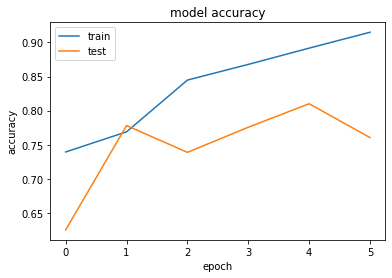

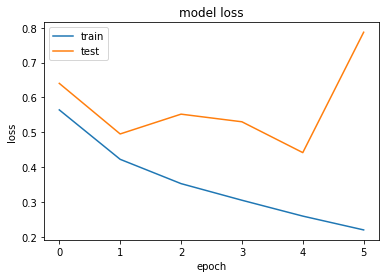

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The model will try to overfit itself but rather save it prior going to the next epoch using necessary callbacks.

#### For better performance use exponential decaying learning rate and specify steps_per_epoch

In [33]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#### Using mlxtend library for quick implementation of confusion matrix.

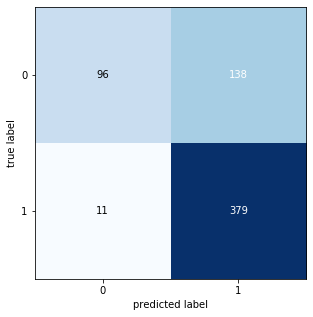

In [34]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()